# Deep Learning Term Project for ECG (DIL700)

# Iteration 5

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
# # Original data

train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)

# Synthetic data

# train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
# train_df = train_df.iloc[:, :-1]
# train_df.rename(columns={'class': 187}, inplace=True)
# test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
# test_df = test_df.iloc[:, :-1]
# test_df.rename(columns={'class': 187}, inplace=True)

# # Put together the training and testing
# full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df = train_df[train_df[187] != '3.0']
test_df = test_df[test_df[187] != '3.0']
full_df = full_df[full_df[187] != '3.0']

train_df = train_df[train_df[187] != 'class']
test_df = test_df[test_df[187] != 'class']
full_df = full_df[full_df[187] != 'class']

train_df.loc[train_df[187] == 4, 187] = 3.0
test_df.loc[test_df[187] == 4, 187] = 3.0
full_df.loc[full_df[187] == 4, 187] = 3.0

train_df.loc[train_df[187] == '4.0', 187] = 3.0
test_df.loc[test_df[187] == '4.0', 187] = 3.0
full_df.loc[full_df[187] == '4.0', 187] = 3.0

train_df.loc[train_df[187] == '0.0', 187] = 0.0
train_df.loc[train_df[187] == '1.0', 187] = 1.0
train_df.loc[train_df[187] == '2.0', 187] = 2.0
train_df.loc[train_df[187] == '3.0', 187] = 3.0

In [4]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [5]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [6]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [7]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [8]:
X = full_df.iloc[:, :-1]
y = full_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [9]:
# Read csv file into df
df_generated = pd.read_csv('./Dataset_mitbih/Synthetic/generated_samples.csv', header=None)
df_generated = df_generated[df_generated[187] != 187]
# Get the first 2000 rows for the generated data
df_generated = df_generated.iloc[:2000, :]

In [10]:
X_generated = df_generated.iloc[:, :-1]
y_generated = df_generated.iloc[:, -1]

In [11]:
# Add to dfs together
X_train = pd.concat([X_train, X_generated], ignore_index=True)
y_train = pd.concat([y_train, y_generated], ignore_index=True)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})


In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.886935,0.439698,0.213568,0.266332,0.261307,0.238693,0.241206,0.228643,0.233668,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.955654,0.893570,0.811530,0.735033,0.615299,0.478936,0.327051,0.213969,0.127494,0.110865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.819444,0.620370,0.393519,0.324074,0.280093,0.212963,0.226852,0.247685,0.268519,0.263889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.782895,0.648026,0.595395,0.595395,0.559211,0.532895,0.486842,0.437500,0.325658,0.217105,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,0.496183,0.515267,0.530534,0.541985,0.538168,0.545802,0.480916,0.370229,0.248092,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71526,0.924037,0.873892,0.303529,0.023341,0.046928,0.091433,0.119312,0.132181,0.169538,0.156241,...,0.001338,0.007638,0.007441,0.005053,0.001765,-0.001221,0.000074,-0.001357,-0.006471,0.005779
71527,0.998419,1.149103,0.485127,0.073428,0.098134,0.222265,0.242714,0.239308,0.294280,0.317506,...,-0.004033,-0.006170,0.018143,-0.004396,-0.006200,-0.000870,0.004434,-0.009313,0.011600,-0.005737
71528,0.999697,1.094748,0.375400,0.066259,0.137694,0.238053,0.223513,0.226602,0.297220,0.281922,...,-0.017650,-0.007597,0.010355,0.001839,-0.007734,0.004406,0.003713,-0.012480,0.006060,-0.001882
71529,0.925218,0.825144,0.250351,0.056180,0.104999,0.121251,0.125076,0.164557,0.201013,0.184540,...,0.004865,0.005076,0.005385,-0.001976,-0.003111,-0.005532,0.001298,-0.003636,-0.003475,0.002376


In [13]:
y_train

0        0.0
1        3.0
2        2.0
3        3.0
4        3.0
        ... 
71526    1.0
71527    1.0
71528    1.0
71529    1.0
71530    1.0
Name: 187, Length: 71531, dtype: float64

In [14]:
y_train_nn

,N,S,V,Q
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
71526,0,1,0,0
71527,0,1,0,0
71528,0,1,0,0
71529,0,1,0,0


In [15]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
18928,0.935760,0.997859,0.526767,0.072805,0.036403,0.081370,0.089936,0.089936,0.077088,0.070664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97196,0.947500,0.765000,0.240000,0.022500,0.042500,0.047500,0.005000,0.000000,0.002500,0.002500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19504,1.000000,0.991736,0.723140,0.479339,0.198347,0.103306,0.190083,0.272727,0.355372,0.388430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97578,0.224359,0.724359,0.820513,0.121795,0.198718,0.583333,0.641026,0.692308,0.698718,0.724359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67613,1.000000,0.673114,0.168279,0.168279,0.117988,0.027079,0.019342,0.065764,0.174081,0.255319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,1.000000,0.462783,0.346278,0.268608,0.252427,0.229773,0.245955,0.258900,0.304207,0.317152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41798,1.000000,0.910072,0.654676,0.266187,0.183453,0.107914,0.104317,0.079137,0.082734,0.064748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49813,0.892057,0.841141,0.329939,0.089613,0.028513,0.004073,0.012220,0.000000,0.061100,0.248473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53114,1.000000,0.635739,0.013746,0.106529,0.089347,0.106529,0.079038,0.096220,0.085911,0.099656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [16]:
y_train=y_train.astype(int)
equilibre_train=y_train.value_counts(sort=False)
print(equilibre_train)

0    57960
3     5207
2     4600
1     3764
Name: 187, dtype: int64


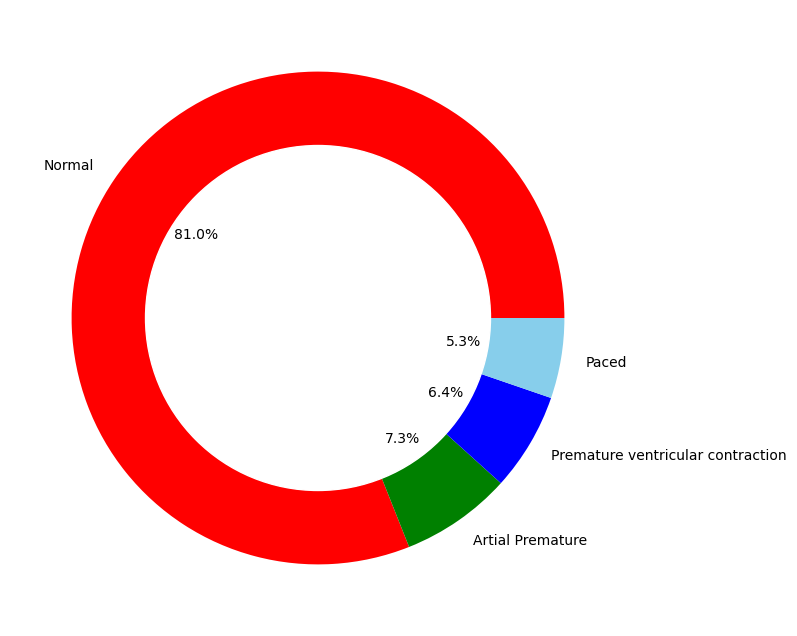

In [17]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [18]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1      556
2     1448
3     1608
Name: 187, dtype: int64


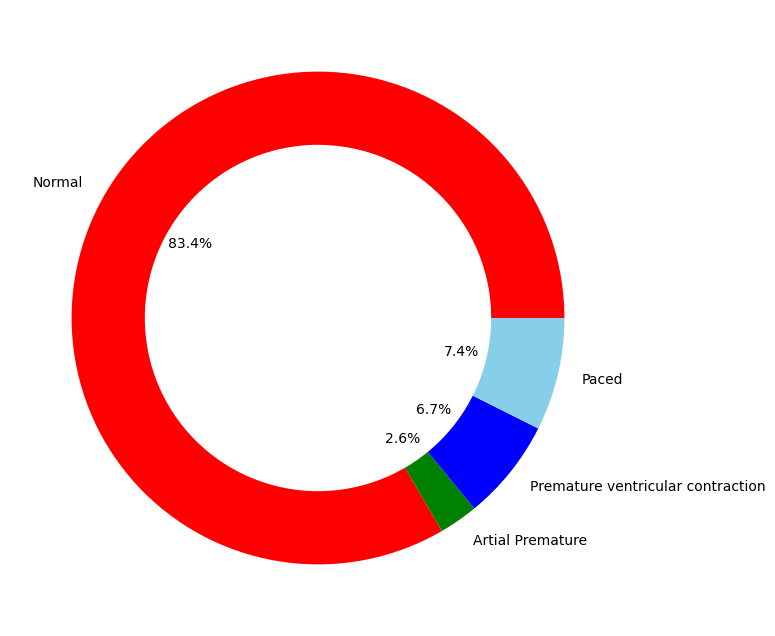

In [19]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Simple ANN

In [20]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
save_model(model_ann, 'ANN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2236/2236 [==============================] - 11s 4ms/step - loss: 0.2011 - accuracy: 0.9419 - val_loss: 0.1414 - val_accuracy: 0.9596
Epoch 2/40
2236/2236 [==============================] - 9s 4ms/step - loss: 0.1199 - accuracy: 0.9657 - val_loss: 0.1085 - val_accuracy: 0.9686
Epoch 3/40
2236/2236 [==============================] - 13s 6ms/step - loss: 0.1004 - accuracy: 0.9714 - val_loss: 0.1009 - val_accuracy: 0.9728
Epoch 4/40
2236/2236 [==============================] - 10s 4ms/step - loss: 0.0882 - accuracy: 0.9747 - val_loss: 0.1105 - val_accuracy: 0.9704
Epoch 5/40
2236/2236 [==============================] - 10s 4ms/step - loss: 0.0806 - accuracy: 0.9766 - val_loss: 0.0824 - val_accuracy: 0.9764
Epoch 6/40
2236/2236 [==============================] - 10s 4ms/step - loss: 0.0737 - accuracy: 0.9781 - val_loss: 0.0814 - val_accuracy: 0.9762
Epoch 7/40
2236/2236 [==============================] - 10s 5ms/step - loss: 0.0685 - accuracy: 0.9800 - val_loss: 0.0754 - val_acc

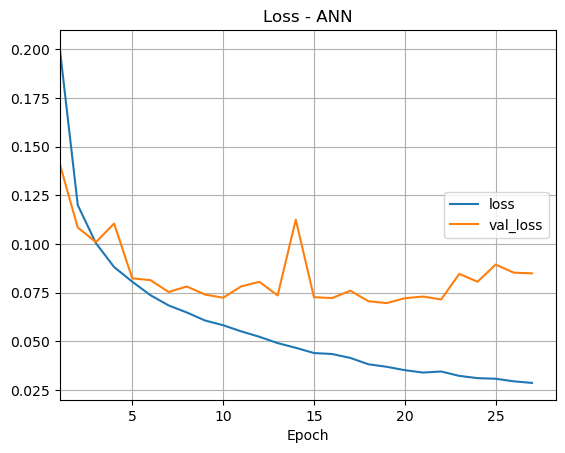

In [21]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

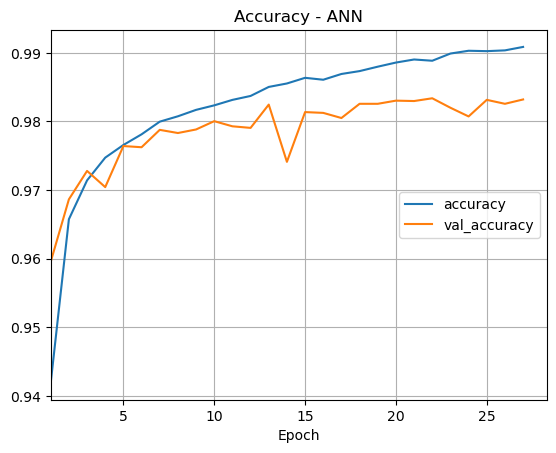

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [24]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Weighted Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

680/680 [==============================] - 1s 985us/step
Weighted Accuracy of ANN:  0.9827419577523125


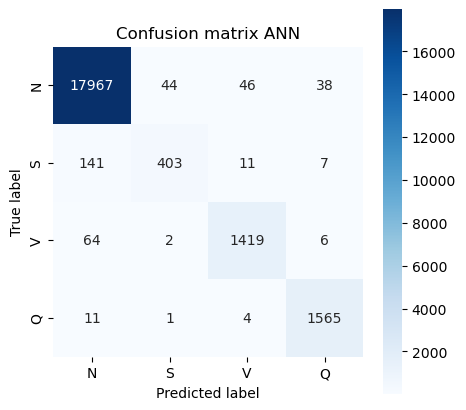

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [26]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)


Accuracy per class:  [0.99292622 0.71708185 0.95171026 0.98987982]
Macro/average accuracy:  0.9128995394283954


In [27]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                           Normal     0.9881    0.9929    0.9905     18095
                 Artial Premature     0.8956    0.7171    0.7964       562
Premature ventricular contraction     0.9588    0.9517    0.9552      1491
                            Paced     0.9684    0.9899    0.9790      1581

                         accuracy                         0.9827     21729
                        macro avg     0.9527    0.9129    0.9303     21729
                     weighted avg     0.9823    0.9827    0.9822     21729



#### False Positive Rate

In [28]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal classes: ", total_abnormal)
print("Total number of wrong predicted abnormal classes: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal classes:  3634
Total number of wrong predicted abnormal classes:  216
Percentage of sick persons that are classified as normal:  0.6957621758380772 %


In [29]:
report = classification_report(y_test, y_pred_ann, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, "ANN with GAN data")

              precision    recall  f1-score   support

         0.0     0.9881    0.9929    0.9905     18095
         1.0     0.8956    0.7171    0.7964       562
         2.0     0.9588    0.9517    0.9552      1491
         3.0     0.9684    0.9899    0.9790      1581

    accuracy                         0.9827     21729
   macro avg     0.9527    0.9129    0.9303     21729
weighted avg     0.9823    0.9827    0.9822     21729



## CNN

In [30]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2236/2236 [==============================] - 23s 8ms/step - loss: 0.1262 - accuracy: 0.9642 - val_loss: 0.1131 - val_accuracy: 0.9655
Epoch 2/40
2236/2236 [==============================] - 18s 8ms/step - loss: 0.0741 - accuracy: 0.9786 - val_loss: 0.0635 - val_accuracy: 0.9799
Epoch 3/40
2236/2236 [==============================] - 18s 8ms/step - loss: 0.0596 - accuracy: 0.9826 - val_loss: 0.0656 - val_accuracy: 0.9808
Epoch 4/40
2236/2236 [==============================] - 18s 8ms/step - loss: 0.0524 - accuracy: 0.9845 - val_loss: 0.0788 - val_accuracy: 0.9745
Epoch 5/40
2236/2236 [==============================] - 18s 8ms/step - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.0599 - val_accuracy: 0.9813
Epoch 6/40
2236/2236 [==============================] - 17s 8ms/step - loss: 0.0400 - accuracy: 0.9877 - val_loss: 0.0542 - val_accuracy: 0.9830
Epoch 7/40
2236/2236 [==============================] - 19s 8ms/step - loss: 0.0364 - accuracy: 0.9892 - val_loss: 0.0375 - val_ac

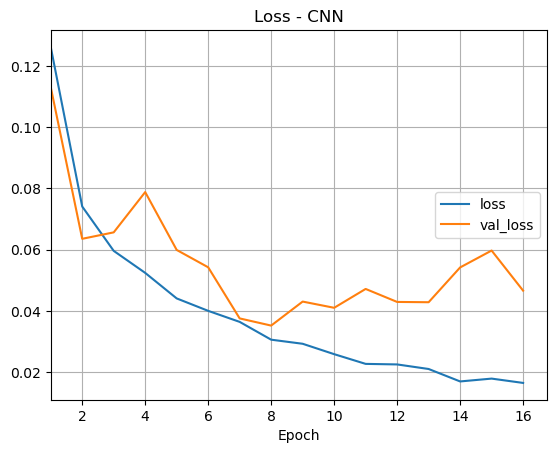

In [31]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

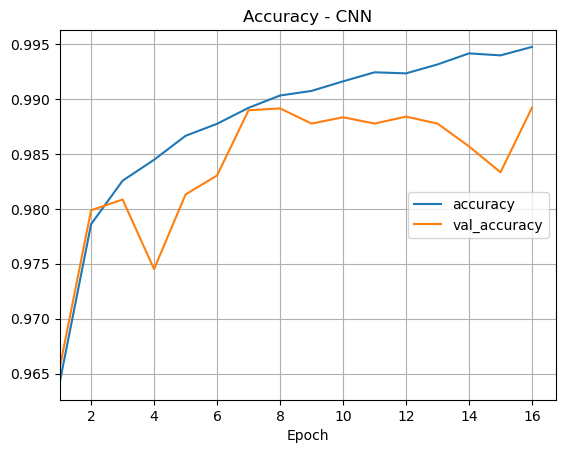

In [32]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [33]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

680/680 [==============================] - 2s 2ms/step
Accuracy of CNN:  0.9882645312715725


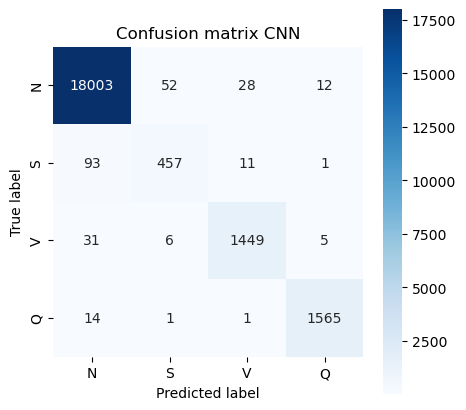

In [34]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [35]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)


Accuracy per class:  [0.99491572 0.81316726 0.97183099 0.98987982]
Macro/average accuracy:  0.9424484477935419


In [36]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

                                   precision    recall  f1-score   support

                           Normal     0.9924    0.9949    0.9937     18095
                 Artial Premature     0.8857    0.8132    0.8479       562
Premature ventricular contraction     0.9731    0.9718    0.9725      1491
                            Paced     0.9886    0.9899    0.9893      1581

                         accuracy                         0.9883     21729
                        macro avg     0.9600    0.9424    0.9508     21729
                     weighted avg     0.9880    0.9883    0.9881     21729



#### False Positive Rate

In [37]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal classes: ", total_abnormal)
print("Total number of wrong predicted abnormal classes: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal classes:  3634
Total number of wrong predicted abnormal classes:  138
Percentage of sick persons that are classified as normal:  0.8855154965211892 %


In [38]:
report = classification_report(y_test, y_pred_cnn, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, "CNN with GAN data")

              precision    recall  f1-score   support

         0.0     0.9924    0.9949    0.9937     18095
         1.0     0.8857    0.8132    0.8479       562
         2.0     0.9731    0.9718    0.9725      1491
         3.0     0.9886    0.9899    0.9893      1581

    accuracy                         0.9883     21729
   macro avg     0.9600    0.9424    0.9508     21729
weighted avg     0.9880    0.9883    0.9881     21729



In [39]:
# model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras', report)